In [21]:
import os
import sys
sys.path.append('../')

from IPython.core.pylabtools import figsize

#from utils import get_intervals
from utils import get_scanpy_lfcs, get_seurat_lfcs, get_ZILN_lfcs, transform

In [2]:
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.multitest as smm

In [3]:
def log_transform(x, scale_factor=10000):
    norm_x = np.log(scale_factor * x/x.sum(0))
    return(norm_x)

# x numpy vector of counts
# transformation to apply to the non-zero elements of x.
def process_counts(x, transformation):
    cell_count = len(x)
    N_0 = np.sum(x == 0)
    N_plus = cell_count - N_0
    t_x = transformation(x[np.where(x > 0)])    
    return(t_x, N_plus, N_0)

# return p-value -- we are using Normal assumption on the means for inference. The null is that the means are the same.
def infer_lfc(m_x, s_x, m_y, s_y):
    diff = m_x - m_y 
    s_hat = np.sqrt((s_x**2) + (s_y**2))
    lb = diff - 1.96*s_hat
    ub = diff + 1.96*s_hat
    # Compute the p-value.
    z_score = diff / s_hat
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
    return(lb,ub,p_value)


In [89]:
# Read in the counts data
data_folder = "../simul/splatter/"
X = pd.read_csv(os.path.join(data_folder, "X.csv")).to_numpy()
Y = pd.read_csv(os.path.join(data_folder, "Y.csv")).to_numpy()
#cell_counts_X = X.sum(axis=1)
#cell_counts_Y = Y.sum(axis=1)
n_genes = Y.shape[0]
print(n_genes)

lfcs = pd.read_csv(os.path.join(data_folder, "fc.csv"))
lfcs2 = pd.read_csv(os.path.join(data_folder, "fc2.csv"))
#idx = np.argsort(lfcs)

# Y_A = Y[:,X.loc[X["trt"] == "A"].index]
# Y_B = Y[:,X.loc[X["trt"] == "B"].index]
# print(Y_A.shape)
# print(Y_B.shape)


4043


In [94]:
X = X.transpose()
Y = Y.transpose()

In [95]:
ziln_lfcs = get_ZILN_lfcs(np.exp(transform(Y)) - 1, np.exp(transform(X)) - 1, eps=1e-3)

/Users/seonghwanjun/Dropbox/seong/scratch/DE-ZILN/notebooks/../utils.py:113: RuntimeWarning: invalid value encountered in scalar subtract
  estimated_lfc = (log_mu_y - log_mu_x) / np.log(2)


In [96]:
ziln_lfcs.shape

(4043,)

In [97]:
gt_lfcs = lfcs["true_log2_fc"]

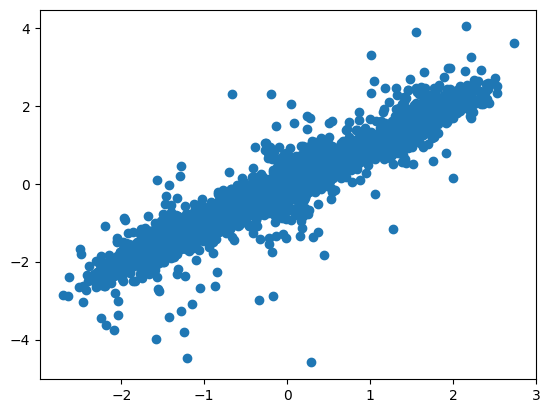

In [98]:
plt.scatter(gt_lfcs, ziln_lfcs)

In [87]:
Y.shape

(4043, 1301)

In [88]:
seurat_lfcs = get_seurat_lfcs(Y.transpose(), X.transpose(), normalize=True)
#scanpy_lfcs = get_scanpy_lfcs(Y.transpose(), X.transpose(), normalize=True)
#seurat_lfcs = get_seurat_lfcs(Y, X, normalize=True)

In [65]:
ii = (ziln_lfcs == np.inf) | (ziln_lfcs == -np.inf)
jj = np.isnan(lfcs2["avg_log2FC"])
print(np.where(ii))
kk = ii | jj

(array([ 628,  781,  948, 1308, 1609, 2296, 2627, 3001, 3333]),)


In [66]:
np.mean((ziln_lfcs[~kk] - gt_lfcs[~kk])**2)

0.11842295640905762

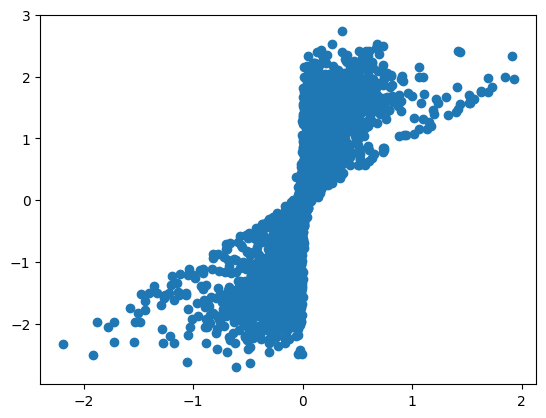

In [79]:
plt.scatter(seurat_lfcs, gt_lfcs)

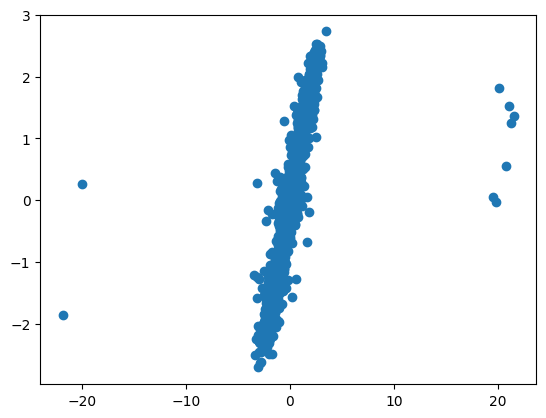

In [82]:
plt.scatter(scanpy_lfcs, gt_lfcs)